## **Assignment 3 - Numerical Optimization & Large Scale Linear Algebra**

This notebook contains the implementation of all tasks from the third assignment for the Numerical Optimization and Large Scale Linear Algebra course

### **Part 1**

### **• Task 1**

<u>**Description**</u>

**Find the vector $\pi$ with**

**i) the Power method**

**ii) solving the corresponding system**

**as they described in paragraph 5.1 and 5.2 of the tutorial. For both methods consider as $\alpha = 0.85$ and stopping criterion $\tau = 10^{-8}$ and the vector $a$ having 1 if it is corresponds to a node with no out links and 0 otherwise. Are the results the same for both methods? Which method seems to be faster? Use Gauss Seidel method for the iterative solution of the system.**

<u>**Solution**</u>

Import some packages

In [1]:
# Importing some packages

import time
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, tril, triu, identity, vstack, hstack
from scipy.sparse.linalg import splu
from matplotlib import pyplot as plt

Load the data and construct the transition matrix using a sparse matrix representation, because of the large amount of data

In [2]:
# Loading the connectivity matrix
connectivity_matrix = pd.read_csv(
    "../data/stanweb.dat",
    sep=r"\s+",
    header=None,
    names=["source_node", "destination_node", "probability"],
)

# Converting to integers
connectivity_matrix["source_node"] = connectivity_matrix["source_node"].astype(int)
connectivity_matrix["destination_node"] = connectivity_matrix[
    "destination_node"
].astype(int)

# Getting the total nodes
total_nodes = connectivity_matrix["source_node"].max()

# Building the transition matrix
transition_matrix = csr_matrix(
    (
        connectivity_matrix["probability"],
        (
            connectivity_matrix["source_node"] - 1,
            connectivity_matrix["destination_node"] - 1,
        ),
    ),
    shape=(total_nodes, total_nodes),
)

Recompute the a vector having 1 if it is corresponds to a node with no out links and 0 otherwise

In [3]:
# Building the a vector (1 or 0)
out_degree = np.asarray(transition_matrix.sum(axis=0)).flatten()
a_vector = (out_degree == 0).astype(int)

Define a method to compute the PageRank vector using the Power method.

In [4]:
def solve_power_method(
    transition_matrix, a_vector, alpha, stopping_criterion, iterations
):
    """
    This function illustrates the Power method for finding the PageRank vector.

    :param transition_matrix: The transition matrix
    :param a_vector: A vector having 1 if it is corresponds to a node with no out links and 0 otherwise
    :param alpha: The alpha parameter
    :param stopping_criterion: the stopping criterion
    :param iterations: The number of iterations
    :return: The PageRank vector and the iteration where the method converged
    """

    # Getting the shape
    (shape_0, shape_1) = transition_matrix.shape

    # Initializing
    v_vector = np.ones(shape_1) / shape_0
    rank_vector = np.ones(shape_1) / shape_0

    # Keeping the first 50 top/bottom nodes
    top_previous = (np.argsort(-rank_vector) + 1)[:50]
    bottom_previous = (np.argsort(rank_vector) + 1)[:50]

    # Tracking changes in 50 top/bottom rankings
    top_diffs = []
    bottom_diffs = []

    # Iterating
    for iteration in range(iterations):

        # Computing the next rank vector
        rank_vector_new = (
            alpha * transition_matrix.T.dot(rank_vector)
            + (alpha * np.dot(a_vector, rank_vector) + (1 - alpha)) * v_vector
        )

        # Get new top/bottom 50 nodes
        top_new = (np.argsort(-rank_vector_new) + 1)[:50]
        bottom_new = (np.argsort(rank_vector_new) + 1)[:50]

        # Updating
        top_diffs.append(len(set(top_new).symmetric_difference(set(top_previous))))
        bottom_diffs.append(len(set(bottom_new).symmetric_difference(bottom_previous)))

        # Updating
        top_previous = top_new
        bottom_previous = bottom_new

        # Checking
        if np.linalg.norm(rank_vector_new - rank_vector, 1) < stopping_criterion:

            break

        # Updating
        rank_vector = rank_vector_new

    # Checking
    if iteration == iterations:

        print("Power method did not converge within max iterations!")

        return None, None, None, None

    else:

        return rank_vector_new, iteration + 1, top_diffs, bottom_diffs

Compute the PageRank vector using the Power method, with the alpha parameter set to 0.85 and a stopping criterion of $10^{-8}$

In [5]:
# Executing the power method
(
    pagerank_vector_power_method_1,
    iteration_power_method_1,
    top_diffs_power_method_1,
    bottom_diffs_power_method_1,
) = solve_power_method(transition_matrix, a_vector, 0.85, np.power(10.0, -8), 2000)

print(
    f"The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration {iteration_power_method_1}"
)

The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration 90


Define a method to identify some top-ranked nodes based on a given PageRank vector

In [6]:
def find_top_ranked_nodes(rank_vector, top=50):
    """
    Returns some top-ranked nodes based on a given PageRank vector.

    :param rank_vector: A PageRank vector
    :param top: How many nodes to find
    :return: The top-ranked nodes
    """

    # Flattening
    rank_vector = rank_vector.flatten()

    # Finding the nodes
    top_nodes = (np.argsort(-rank_vector) + 1)[:top]

    return top_nodes

Find the 50 top-ranked nodes

In [7]:
# Getting the top 50 nodes
top_50_nodes_power_method_1 = find_top_ranked_nodes(pagerank_vector_power_method_1)

print(f"The top 50 nodes using the Power method are:\n{top_50_nodes_power_method_1}")

The top 50 nodes using the Power method are:
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750  95163 251796 272442 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
 120708  62478 161890 176790 137632  77999 221087  17781 183004  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


Define a function to compute the PageRank vector by solving the linear system and using the Gauss Seidel method

In [8]:
def solve_system_gauss_seidel(transition_matrix, alpha, stopping_criterion, iterations):
    """
    This function is used to solve the system by using the Gauss Seidel method.

    :param transition_matrix: The transition matrix
    :param alpha: The alpha parameter
    :param stopping_criterion: the stopping criterion
    :param iterations: The number of iterations
    :return: The PageRank vector and the iteration where the method converged
    """

    # Getting the shape
    (shape_0, shape_1) = transition_matrix.shape

    # Computing the A matrix
    a_matrix = (identity(shape_0, format="csc") - alpha * transition_matrix).T

    # Splitting A matrix
    l_matrix = splu(tril(a_matrix, 0, format="csc"))
    u_matrix = triu(a_matrix, 1, format="csc")

    # Initializing
    v_vector = np.ones(shape_1) / shape_0
    rank_vector = np.ones(shape_1) / shape_0

    # Keeping the first 50 top/bottom nodes
    top_previous = (np.argsort(-rank_vector) + 1)[:50]
    bottom_previous = (np.argsort(rank_vector) + 1)[:50]

    # Tracking changes in 50 top/bottom rankings
    top_diffs = []
    bottom_diffs = []

    # Iterating
    for iteration in range(iterations):

        # Getting the next rank vector
        rank_vector_new = l_matrix.solve(v_vector - u_matrix.dot(rank_vector))

        # Get new top/bottom 50 nodes
        top_new = (np.argsort(-rank_vector_new) + 1)[:50]
        bottom_new = (np.argsort(rank_vector_new) + 1)[:50]

        # Updating
        top_diffs.append(len(set(top_new).symmetric_difference(set(top_previous))))
        bottom_diffs.append(len(set(bottom_new).symmetric_difference(bottom_previous)))

        # Updating
        top_previous = top_new
        bottom_previous = bottom_new

        if np.linalg.norm(rank_vector_new - rank_vector, 1) < stopping_criterion:

            break

        # Updating
        rank_vector = rank_vector_new

    # Checking
    if iteration == iterations:

        print("Gauss-Seidel did not converge within max iterations!")

        return None, None, None, None

    else:

        return (
            rank_vector_new / np.sum(rank_vector_new),
            iteration + 1,
            top_diffs,
            bottom_diffs,
        )

Compute the PageRank vector by solving the corresponding linear system, with the alpha parameter set to 0.85 and a stopping criterion of $10^{-8}$

In [9]:
# Solving the system
(
    pagerank_vector_gauss_seidel_1,
    iteration_gauss_seidel_1,
    top_diffs_gauss_seidel_1,
    bottom_diffs_gauss_seidel_1,
) = solve_system_gauss_seidel(transition_matrix, 0.85, np.power(10.0, -8), 2000)

print(
    f"Solving the system using Gauss Seidel with alpha=0.85 and stopping criterion=1e-08 converged at iteration {iteration_gauss_seidel_1}"
)

Solving the system using Gauss Seidel with alpha=0.85 and stopping criterion=1e-08 converged at iteration 62


In [10]:
# Getting the top 50 nodes
top_50_nodes_gauss_seidel_1 = find_top_ranked_nodes(pagerank_vector_gauss_seidel_1)


print(
    f"The top 50 nodes by solving the linear system are:\n{top_50_nodes_gauss_seidel_1}"
)

The top 50 nodes by solving the linear system are:
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
 120708  62478 161890 221087 183004 176790 137632  77999  17781  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


From the results above, we observe that both methods produce nearly identical rankings for the first 50 nodes/pages. Specifically, the differences are highlighted below

In [11]:
# Getting the different positions
different_positions = np.where(
    top_50_nodes_power_method_1 != top_50_nodes_gauss_seidel_1
)[0]

print(f"Number of different positions: {len(different_positions)}")

# Iterating
for position in different_positions:

    print(
        f"At position {position + 1}: Power methos = {top_50_nodes_power_method_1[position]}, Linear System = {top_50_nodes_gauss_seidel_1[position]}"
    )

# Nodes in 'top_50_nodes_power_method_1' and not in 'top_50_nodes_gauss_seidel_1'
nodes_1 = np.setdiff1d(top_50_nodes_power_method_1, top_50_nodes_gauss_seidel_1)

# Nodes in 'top_50_nodes_gauss_seidel_1' and not in 'top_50_nodes_power_method_1'
nodes_2 = np.setdiff1d(top_50_nodes_gauss_seidel_1, top_50_nodes_power_method_1)

print(
    f"\nNodes in top-50 list of Power method which are not in the corresponding list of the linear system:\n{nodes_1} (Total: {len(nodes_1)})\n"
)

print(
    f"Nodes in top-50 list of linear system method which are not in the corresponding list of the Power method:\n{nodes_2} (Total: {len(nodes_2)})"
)

Number of different positions: 8
At position 14: Power methos = 95163, Linear System = 272442
At position 16: Power methos = 272442, Linear System = 95163
At position 34: Power methos = 176790, Linear System = 221087
At position 35: Power methos = 137632, Linear System = 183004
At position 36: Power methos = 77999, Linear System = 176790
At position 37: Power methos = 221087, Linear System = 137632
At position 38: Power methos = 17781, Linear System = 77999
At position 39: Power methos = 183004, Linear System = 17781

Nodes in top-50 list of Power method which are not in the corresponding list of the linear system:
[] (Total: 0)

Nodes in top-50 list of linear system method which are not in the corresponding list of the Power method:
[] (Total: 0)


Define a function to evaluate the performance of each method in terms of the runtime to convergence and calculate the corresponding PageRank vector

In [12]:
def test_speed(
    method, transition_matrix, a_vector, alpha, stopping_criterion, iterations
):
    """
    This function is used to compute the average runtime of a method to converge

    :param method: Which method to use
    :param transition_matrix: The transition matrix
    :param a_vector: A vector having 1 if it is corresponds to a node with no out links and 0 otherwise
    :param alpha: The alpha parameter
    :param stopping_criterion: the stopping criterion
    :param iterations: The number of iterations
    """

    # Initializing a variable keeping the runtimes
    time_to_run = 0

    # Checking which method to use
    if method == "power":

        # Testing 10 times
        for test_iteration in range(10):

            # Getting the start time
            start_time = time.time()

            # Executing the power method
            _ = solve_power_method(
                transition_matrix, a_vector, alpha, stopping_criterion, iterations
            )

            # Getting the end time
            end_time = time.time()

            # Updating
            time_to_run += end_time - start_time

        print(
            f"Power Method with alpha={alpha} and stopping criterion=1e-08 runs in: {time_to_run / 10:.4f}s."
        )

    else:

        # Testing 10 times
        for test_iteration in range(10):

            # Getting the start time
            start_time = time.time()

            # Executing the method
            _ = solve_system_gauss_seidel(
                transition_matrix, alpha, stopping_criterion, iterations
            )

            # Getting the end time
            end_time = time.time()

            # Updating
            time_to_run += end_time - start_time

        print(
            f"Solving the system using Gauss Seidel with alpha={alpha} and stopping criterion=1e-08 runs in: {time_to_run / 10:.4f}s."
        )

Compute the average runtime of the Power method

In [13]:
test_speed("power", transition_matrix, a_vector, 0.85, np.power(10.0, -8), 2000)

Power Method with alpha=0.85 and stopping criterion=1e-08 runs in: 3.5023s.


Compute the average runtime by solving the linear system

In [14]:
test_speed("system", transition_matrix, None, 0.85, np.power(10.0, -8), 2000)

Solving the system using Gauss Seidel with alpha=0.85 and stopping criterion=1e-08 runs in: 4.3413s.


Additionally, the results show that the Power Method converges more slowly than the Linear System method, requiring 90 iterations compared to 62. However, in terms of execution time, the Power Method performs better, completing in approximately 3.50 seconds, whereas the Linear System method takes around 4.34 seconds

### **• Task 2**

<u>**Description**</u>

**Do the previous task with $\alpha = 0.99$. Your remarks on the convergence speed. Did the ranking of the first 50 nodes changed?**

<u>**Solution**</u>

Compute the PageRank vector using the Power method, with the alpha parameter set to 0.99 and a stopping criterion of $10^{-8}$

In [15]:
# Executing the power method
(
    pagerank_vector_power_method_2,
    iteration_power_method_2,
    top_diffs_power_method_2,
    bottom_diffs_power_method_2,
) = solve_power_method(transition_matrix, a_vector, 0.99, np.power(10.0, -8), 2000)

print(
    f"The power method with alpha=0.99 and stopping criterion=1e-08 converged at iteration {iteration_power_method_2}"
)

The power method with alpha=0.99 and stopping criterion=1e-08 converged at iteration 1385


In [16]:
# Getting the top 50 nodes
top_50_nodes_power_method_2 = find_top_ranked_nodes(pagerank_vector_power_method_2)

print(f"The top 50 nodes using the Power method are:\n{top_50_nodes_power_method_2}")

The top 50 nodes using the Power method are:
[ 89073 281772 174665 226411 179645 271409 262860 136821  68889  77988
 116530  95163 272442 251796  65580 119479 241454 245765  58048  14785
  77084 117152 152337 181701 235496 247241 259455  62478 120708  77999
 137632 176790  17781 183004 221087  96745 119822  27904 272762  96196
 229580  95366 234962 169234 236644 144494  58612  49047 264187  85040]


In [17]:
# Solving the system
(
    pagerank_vector_gauss_seidel_2,
    iteration_gauss_seidel_2,
    top_diffs_gauss_seidel_2,
    bottom_diffs_gauss_seidel_2,
) = solve_system_gauss_seidel(transition_matrix, 0.99, np.power(10.0, -8), 2000)

print(
    f"Solving the system using Gauss Seidel with alpha=0.99 and stopping criterion=1e-08 converged at iteration {iteration_gauss_seidel_2}"
)

Solving the system using Gauss Seidel with alpha=0.99 and stopping criterion=1e-08 converged at iteration 968


In [18]:
# Getting the top 50 nodes
top_50_nodes_gauss_seidel_2 = find_top_ranked_nodes(pagerank_vector_gauss_seidel_2)

print(
    f"The top 50 nodes by solving the linear system are:\n{top_50_nodes_gauss_seidel_2}"
)

The top 50 nodes by solving the linear system are:
[ 89073 281772 174665 226411 179645 271409 262860 136821  68889  77988
 116530 272442 251796  95163  65580 119479 241454 245765  58048  14785
  77084 117152 152337 181701 235496 259455 247241 120708  62478 221087
 183004 176790 137632  77999  17781  96745 119822  27904 272762  96196
 229580  95366 234962 169234  49047 137425 275885  58612  85040 236644]


From the results above, we can observe again that both methods produce nearly identical rankings for the first 50 nodes/pages but with more differences than the previous task. Specifically, the differences are highlighted below

In [19]:
# Getting the different positions
different_positions = np.where(
    top_50_nodes_power_method_2 != top_50_nodes_gauss_seidel_2
)[0]

print(f"Number of different positions: {len(different_positions)}")

# Iterating
for position in different_positions:

    print(
        f"At position {position + 1}: Power methos = {top_50_nodes_power_method_2[position]}, Linear System = {top_50_nodes_gauss_seidel_2[position]}"
    )

# Nodes in 'top_50_nodes_power_method_2' and not in 'top_50_nodes_gauss_seidel_2'
nodes_1 = np.setdiff1d(top_50_nodes_power_method_2, top_50_nodes_gauss_seidel_2)

# Nodes in 'top_50_nodes_gauss_seidel_2' and not in 'top_50_nodes_power_method_2'
nodes_2 = np.setdiff1d(top_50_nodes_gauss_seidel_2, top_50_nodes_power_method_2)

print(
    f"\nNodes in top-50 list of Power method which are not in the corresponding list of the linear system:\n{nodes_1} (Total: {len(nodes_1)})\n"
)

print(
    f"Nodes in top-50 list of linear system method which are not in the corresponding list of the Power method:\n{nodes_2} (Total: {len(nodes_2)})"
)

Number of different positions: 18
At position 12: Power methos = 95163, Linear System = 272442
At position 13: Power methos = 272442, Linear System = 251796
At position 14: Power methos = 251796, Linear System = 95163
At position 26: Power methos = 247241, Linear System = 259455
At position 27: Power methos = 259455, Linear System = 247241
At position 28: Power methos = 62478, Linear System = 120708
At position 29: Power methos = 120708, Linear System = 62478
At position 30: Power methos = 77999, Linear System = 221087
At position 31: Power methos = 137632, Linear System = 183004
At position 33: Power methos = 17781, Linear System = 137632
At position 34: Power methos = 183004, Linear System = 77999
At position 35: Power methos = 221087, Linear System = 17781
At position 45: Power methos = 236644, Linear System = 49047
At position 46: Power methos = 144494, Linear System = 137425
At position 47: Power methos = 58612, Linear System = 275885
At position 48: Power methos = 49047, Linear S

Now let's see what happened in the top-50 ranking between the two tasks

In [20]:
# Forming a dataframe with all the top-50 nodes
top_50_nodes = pd.DataFrame(
    {
        "Power Method - Alpha=0.85": top_50_nodes_power_method_1,
        "Linear System - Alpha=0.85": top_50_nodes_gauss_seidel_1,
        "Power Method - Alpha=0.99": top_50_nodes_power_method_2,
        "Linear System Method - Alpha=0.99": top_50_nodes_gauss_seidel_2,
    }
)

# Showing
top_50_nodes

,Power Method - Alpha=0.85,Linear System - Alpha=0.85,Power Method - Alpha=0.99,Linear System Method - Alpha=0.99
0,89073,89073,89073,89073
1,226411,226411,281772,281772
2,241454,241454,174665,174665
3,262860,262860,226411,226411
4,134832,134832,179645,179645
5,234704,234704,271409,271409
6,136821,136821,262860,262860
7,68889,68889,136821,136821
8,105607,105607,68889,68889
9,69358,69358,77988,77988


After analyzing the results above, we observe that the rankings differ significantly between the two alpha values (0.85 and 0.99) across both methods, although the internal similarities within each method remain higher, as previously noted

Compute the average runtime of the Power method

In [54]:
test_speed("power", transition_matrix, a_vector, 0.99, np.power(10.0, -8), 2000)

Power Method with alpha=0.99 and stopping criterion=1e-08 runs in: 66.5504s.


Compute the average runtime by solving the linear system

In [55]:
test_speed("system", transition_matrix, None, 0.99, np.power(10.0, -8), 2000)

Solving the system using Gauss Seidel with alpha=0.99 and stopping criterion=1e-08 runs in: 57.6454s.


Additionally, the results show that both methods converge more slowly than before, which is expected due to the increased alpha value. Once again, the Power Method converges more slowly than the Linear System method, requiring 1385 iterations compared to 968. In terms of execution time, the Power Method does not remain faster, completing in approximately 66.55 seconds, while the Linear System method takes around 57.64 seconds

### **• Task 3**

<u>**Description**</u>

**When we use the power method do all the components of $\pi$ converge at the same speed to their limits? If not which of the converge faster: those that correspond to important nodes or to non important? Do you observe the same behavior when you find $\pi$ through the solution of the linear system?**

<u>**Solution**</u>

To address this task, I tracked the number of changes in the top 50 (important) and bottom 50 (less important) pages/nodes during each iteration for both methods. This allowed me to observe how quickly the important and non-important nodes converge to their final rankings, even before the overall method has fully converged. This approach highlights the iteration at which changes become minimal or reach zero

Define a function to normalize the data in a given list of node changes using the min-max normalization

In [21]:
def normalize(node_changes):
    """
    This function is used to normalize the data for a given list of node changes

    :param node_changes: A list with node changes
    :return: A normalized form
    """

    # Converting to array
    node_changes = np.array(node_changes)

    # Normalizing (min-max normalization)
    normalized_node_changes = (node_changes - node_changes.min()) / (
        node_changes.max() - node_changes.min()
    )

    return normalized_node_changes

Define a function to visualize the changes in the top and bottom 50 pages/nodes during each iteration for both methods

In [22]:
def visualize_convergence(
    top_power_method,
    bottom_power_method,
    top_gauss_seidel,
    bottom_gauss_seidel,
    alpha,
    step,
):
    """
    This function is used to show the changes in top and bottom 50 nodes for both methods.

    :param top_power_method: The changes in the top 50 nodes from the power method
    :param bottom_power_method: The changes in the bottom 50 nodes from the power method
    :param top_gauss_seidel: The changes in the top 50 nodes from the linear system method
    :param bottom_gauss_seidel: The changes in the bottom 50 nodes from the linear system method
    :param alpha: The parameter alpha
    :param step: The step for the x-axis
    :return: None
    """

    # Getting the x-axis values
    x_axis_power_method = np.arange(1, len(top_power_method) + 1)
    x_axis_gauss_seidel = np.arange(1, len(top_gauss_seidel) + 1)

    # Creating two subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

    # Plotting for the power method
    axs[0].plot(x_axis_power_method, top_power_method, label="Top 50", color="blue")
    axs[0].plot(
        x_axis_power_method, bottom_power_method, label="Bottom 50", color="orange"
    )

    # Setting some plot parameters
    axs[0].set_title("Power Method")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Changes")
    axs[0].set_xticks(np.arange(0, len(x_axis_power_method) + 1, step))
    axs[0].legend()
    axs[0].grid(True)

    # Plotting for the linear system method (gauss seidel)
    axs[1].plot(x_axis_gauss_seidel, top_gauss_seidel, label="Top 50", color="blue")
    axs[1].plot(
        x_axis_gauss_seidel, bottom_gauss_seidel, label="Bottom 50", color="orange"
    )

    # Setting some plot parameters
    axs[1].set_title("Linear System Method - Gauss Seidel")
    axs[1].set_xlabel("Iteration")
    axs[1].set_xticks(np.arange(0, len(x_axis_gauss_seidel) + 1, step))
    axs[1].legend()
    axs[1].grid(True)

    # Adding atitle
    fig.suptitle(
        f"Top-Bottom 50 Node Changes Over Iterations with alpha={alpha}", fontsize=16
    )

    # Showing the plots
    plt.tight_layout()
    plt.show()

**• Case 1 - Alpha Parameter = 0.85**

Normalize the data

In [23]:
# Normalizing
top_power_method_1 = normalize(top_diffs_power_method_1)
bottom_power_method_1 = normalize(bottom_diffs_power_method_1)
top_gauss_seidel_1 = normalize(top_diffs_gauss_seidel_1)
bottom_gauss_seidel_1 = normalize(bottom_diffs_gauss_seidel_1)

Visualize

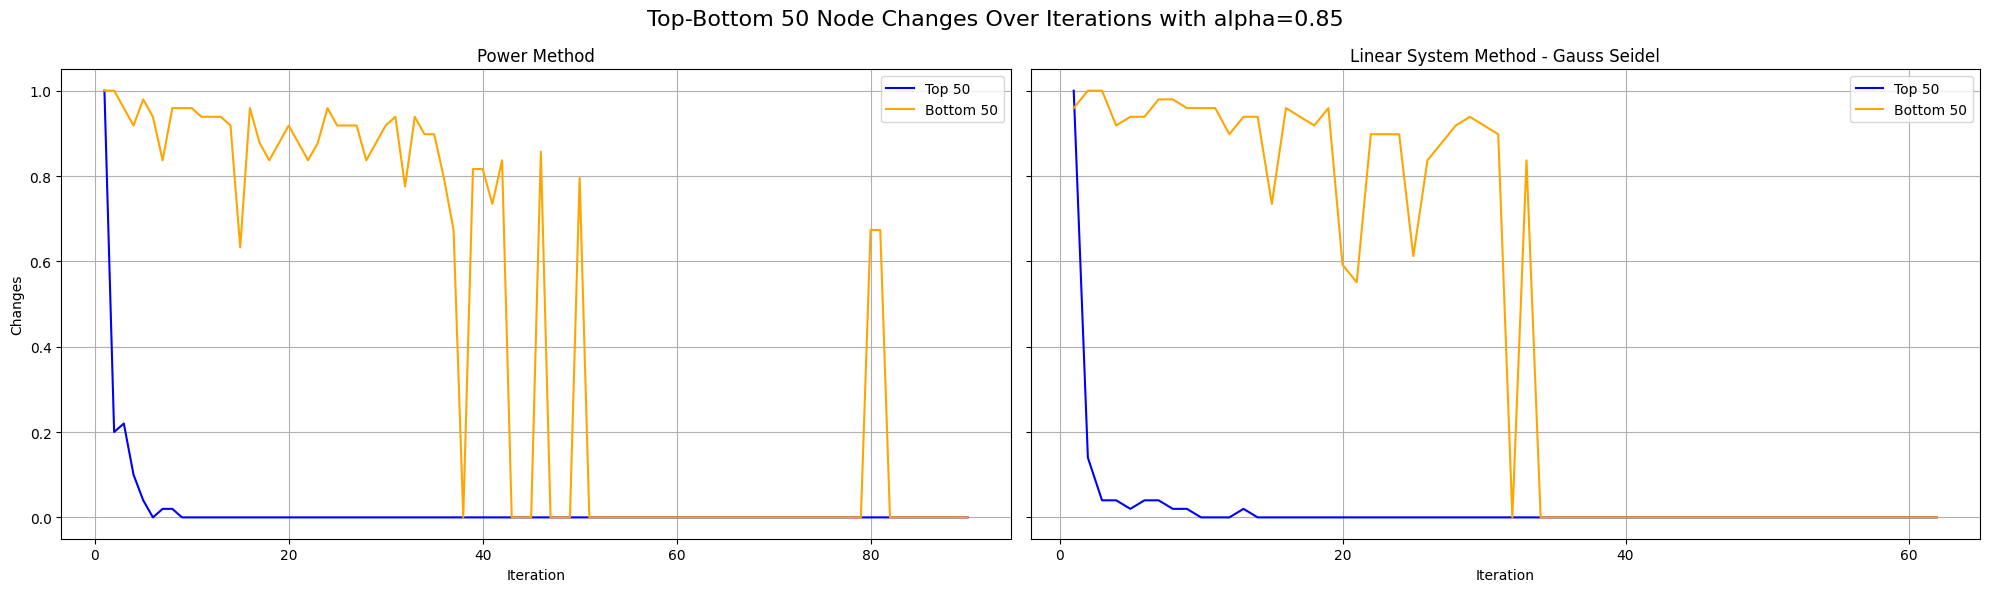

In [24]:
# Showing the changes
visualize_convergence(
    top_power_method_1,
    bottom_power_method_1,
    top_gauss_seidel_1,
    bottom_gauss_seidel_1,
    0.85,
    20,
)

From the charts above, we can observe that in both methods, the most important nodes converge faster than the less important ones. The changes in the top 50 pages drop to zero after a certain number of iterations, indicating that they have reached their final positions in the overall PageRank vector

**• Case 1 - Alpha Parameter = 0.99**

Normalize the data

In [25]:
# Normalizing
top_power_method_2 = normalize(top_diffs_power_method_2)
bottom_power_method_2 = normalize(bottom_diffs_power_method_2)
top_gauss_seidel_2 = normalize(top_diffs_gauss_seidel_2)
bottom_gauss_seidel_2 = normalize(bottom_diffs_gauss_seidel_2)

Visualize

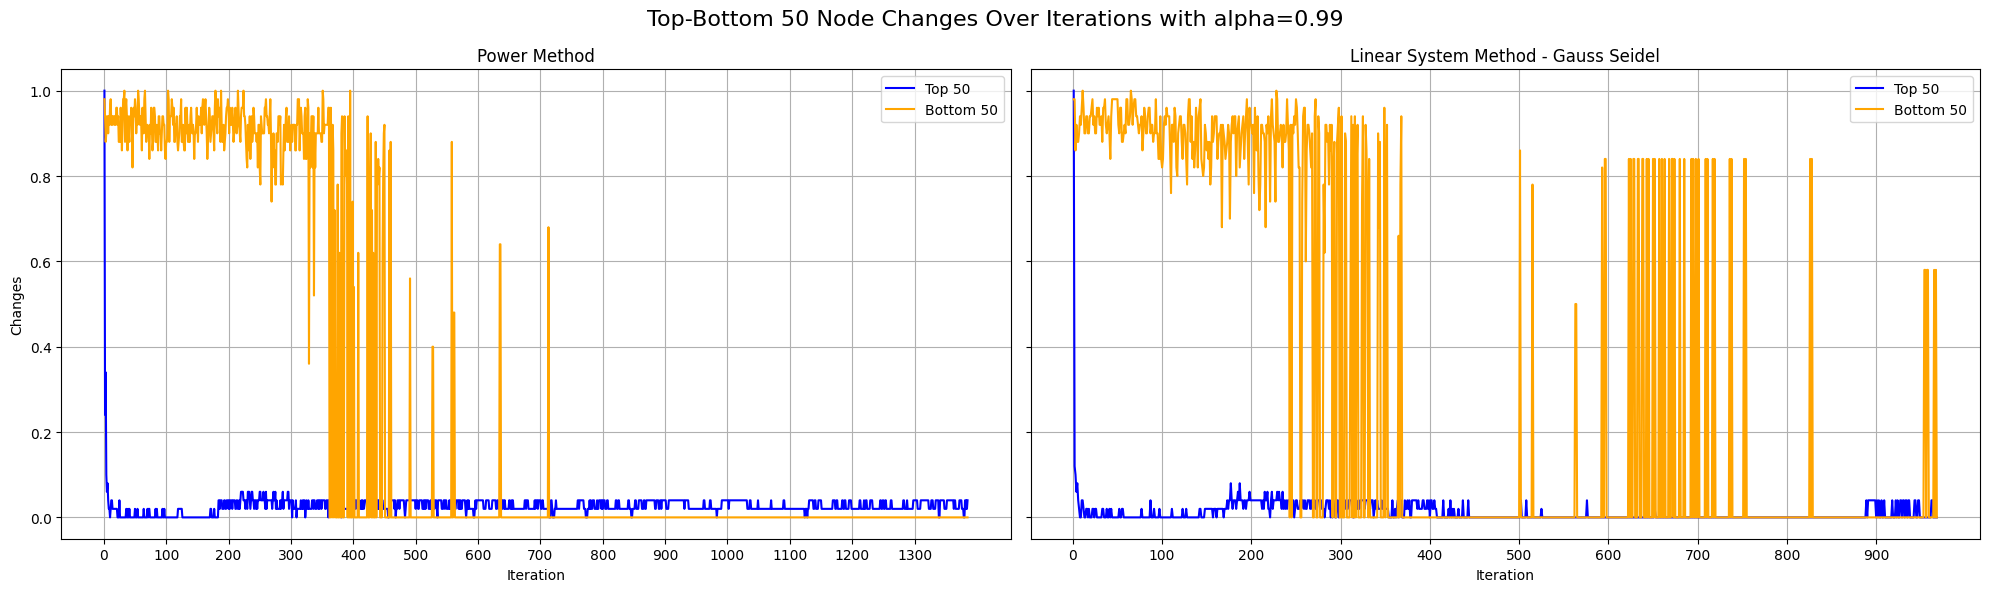

In [26]:
# Showing the changes
visualize_convergence(
    top_power_method_2,
    bottom_power_method_2,
    top_gauss_seidel_2,
    bottom_gauss_seidel_2,
    0.99,
    100
)

In the case where the alpha parameter is set to 0.99, both methods show that changes in the top 50 nodes remain consistently lower than those in the bottom 50 nodes throughout all iterations, though they do not drop to zero as observed in the previous case. Interestingly, unlike before, the Power Method shows faster convergence among the bottom 50 nodes, while in the Linear System method, the top 50 (more important) nodes appear to converge faster, as their changes remain minimal across most iterations compared to the less important ones.

### **Part 2**

### **• Task 1**

<u>**Description**</u>

**You now create a new web page $X$ (thus adding a node to the web graph). $X$ has neither in-links, nor out-links. Let $\tilde{\pi} = (\tilde{\pi}_1, \tilde{\pi}_2, \ldots \tilde{\pi}_n)$ denote the vector of new PageRanks of the $n$ old web pages, and $x$ denote the new PageRank of page $X$: In other words, $(\tilde{\pi}_1, \tilde{\pi}_2, \ldots, \tilde{\pi}_n, x)$ is the PageRank vector of the new web graph. Write $\tilde{\pi}$ and $x$ in terms of $\pi$: Comment on how the PageRanks of the older pages changed due to the addition of the new page (remember $n$ is a very large number). Hint: Use the stationary equations to calculate PageRank, not the iterative approach.**

<u>**Solution**</u>

Form the new transition matrix adding the new page X

In [27]:
# Getting the rows of the initial transition matrix
shape_0 = transition_matrix.shape[0]

# Setting no in-links for the X page
new_column_x = csr_matrix((shape_0, 1))

# Appending
transition_matrix_2 = hstack([transition_matrix, new_column_x], format='csr')

# Creating a new row with a 1 at the X page (link with X)
new_row_x = np.zeros(shape_0 + 1)
new_row_x[-1] = 1

# Appending
transition_matrix_2 = vstack([transition_matrix_2, csr_matrix(new_row_x)], format='csr')

Recompute the a vector having 1 if it is corresponds to a node with no out links and 0 otherwise

In [28]:
# Building the a vector (1 or 0)
out_links_2 = np.asarray(transition_matrix_2.sum(axis=0)).flatten()
a_vector_2 = (out_links_2 == 0).astype(int)

Compute the new PageRank using the power method with alpha equals to 0.85 and stopping criterion equals to $10^{-8}$

In [29]:
# Executing the power method
pagerank_vector_power_method_3, iteration_power_method_3, _, _ = solve_power_method(
    transition_matrix_2, a_vector_2, 0.85, np.power(10.0, -8), 2000
)

print(
    f"The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration {iteration_power_method_3}"
)

The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration 90


Find the rank of the new page X

In [30]:
# Sorting
sorted_ranks = (np.argsort(-pagerank_vector_power_method_3.flatten()))

# Finding the rank of the page x
rank_x = np.where(sorted_ranks == shape_0)[0][0]

print(f"The rank of the new page X is: {rank_x}")

The rank of the new page X is: 49282


Find the top 50 nodes based on the new PageRank

In [31]:
# Getting the new top 50 nodes
top_50_nodes_power_method_3 = find_top_ranked_nodes(pagerank_vector_power_method_3)

print(
    f"The top 50 nodes based on the new PageRank are:\n{top_50_nodes_power_method_3}\n"
)

print(
    f"The previous top 50 nodes before adding the page X are:\n{top_50_nodes_power_method_1}"
)

The top 50 nodes based on the new PageRank are:
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 251796 272442  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
  62478 120708 161890 183004 221087 176790  77999 137632  17781  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]

The previous top 50 nodes before adding the page X are:
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750  95163 251796 272442 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
 120708  62478 161890 176790 137632  77999 221087  17781 183004  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


As observed from the results above, some pages have different rankings in the updated PageRank. Below, we provide a detailed view of the rank changes for the first 50 nodes

In [32]:
# Iterating over the initial top 50 nodes
for rank, node in enumerate(top_50_nodes_power_method_1):

    # Finding the rank of the current node in the new top 50 nodes
    new_rank = np.where(top_50_nodes_power_method_3 == node)[0][0]

    # Checking if it is different        
    if new_rank != rank:

        print(f"Node {node} moved from rank {rank + 1} to index {new_rank + 1}")

Node 95163 moved from rank 14 to index 16
Node 251796 moved from rank 15 to index 14
Node 272442 moved from rank 16 to index 15
Node 120708 moved from rank 31 to index 32
Node 62478 moved from rank 32 to index 31
Node 176790 moved from rank 34 to index 36
Node 137632 moved from rank 35 to index 38
Node 77999 moved from rank 36 to index 37
Node 221087 moved from rank 37 to index 35
Node 17781 moved from rank 38 to index 39
Node 183004 moved from rank 39 to index 34


Compare the changes in the overall ranking to the PageRank results before adding page X

In [33]:
# Sorting
sorted_previous_ranks = np.argsort(-pagerank_vector_power_method_1.flatten())
sorted_new_ranks_without_x = np.argsort(
    -pagerank_vector_power_method_3[: len(pagerank_vector_power_method_1)].flatten()
)

# Getting the different positions
different_positions = np.where(sorted_new_ranks_without_x != sorted_previous_ranks)[0]

print(f"Number of different positions: {len(different_positions)}")

Number of different positions: 55178


### **• Task 2**

<u>**Description**</u>

**Unsatisfied with the PageRank of your page $X$; you create another page $Y$ (with no in-links) that links to $X$: What are the PageRanks of all the $n + 2$ pages now? Does the PageRank of $X$ improve?**

<u>**Solution**</u>

Form the new transition matrix adding the new page Y

In [34]:
# Setting no in-links for the page Y
new_column_y = csr_matrix((shape_0 + 1, 1))

# Appending
transition_matrix_3 = hstack([transition_matrix_2, new_column_y], format='csr')

# Y links to X only
new_row_y = np.zeros(shape_0 + 2)
new_row_y[shape_0] = 1

# Appending
transition_matrix_3 = vstack([transition_matrix_3, csr_matrix(new_row_y)], format='csr')

Recompute the a vector having 1 if it is corresponds to a node with no out links and 0 otherwise

In [35]:
# Building the a vector (1 or 0)
out_links_3 = np.asarray(transition_matrix_3.sum(axis=0)).flatten()
a_vector_3 = (out_links_3 == 0).astype(int)

Compute the new PageRank using the power method with alpha equals to 0.85 and stopping criterion equals to $10^{-8}$

In [36]:
# Executing the power method
pagerank_vector_power_method_4, iteration_power_method_4, _, _ = solve_power_method(
    transition_matrix_3, a_vector_3, 0.85, np.power(10.0, -8), 2000
)

print(
    f"The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration {iteration_power_method_4}"
)

The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration 90


Find the ranks of the new pages X and Y

In [37]:
# Sorting
sorted_ranks_2 = (np.argsort(-pagerank_vector_power_method_4.flatten()))

# Finding the ranks of the pages X and Y
rank_x = np.where(sorted_ranks_2 == shape_0)[0][0]
rank_y = np.where(sorted_ranks_2 == shape_0+1)[0][0]

print(f"The rank of the new page X is: {rank_x}\n")
print(f"The rank of the new page Y is: {rank_y}")

The rank of the new page X is: 16180

The rank of the new page Y is: 261605


From the results above, we can see that the rank of page X improved significantly (from 49282 to 16180) after adding page Y, which links to page X (a completely logical outcome). The rank of the page Y is very low

### **• Task 3**

<u>**Description**</u>

**Still unsatisfied, you create a third page $Z$: How should you set up the links on your three pages so as to maximize the PageRank of $X$?**

<u>**Solution**</u>

After conducting numerous experiments, I found that the optimal setup for maximizing the PageRank of page X, using pages Y and Z, is as follows:

- X links to itself
- Y links to X
- Z links to Y

In this configuration, both Z and Y ultimately transfer all their rank to X

Form the new transition matrix adding the new page Z

In [38]:
# Setting no in-links for the page Z
new_col_z = csr_matrix((shape_0 + 2, 1))

# Appending
transition_matrix_4 = hstack([transition_matrix_3, new_col_z], format="csr")

# Z links to X only
new_row_z = np.zeros(shape_0 + 3)
new_row_z[shape_0] = 1

# Appending
transition_matrix_4 = vstack([transition_matrix_4, csr_matrix(new_row_z)], format="csr")

Recompute the a vector having 1 if it is corresponds to a node with no out links and 0 otherwise

In [39]:
# Building the a vector (1 or 0)
out_links_4 = np.asarray(transition_matrix_4.sum(axis=0)).flatten()
a_vector_4 = (out_links_4 == 0).astype(int)

Compute the new PageRank using the power method with alpha equals to 0.85 and stopping criterion equals to $10^{-8}$

In [40]:
# Executing the power method
pagerank_vector_power_method_5, iteration_power_method_5, _, _ = solve_power_method(
    transition_matrix_4, a_vector_4, 0.85, np.power(10.0, -8), 2000
)

print(
    f"The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration {iteration_power_method_5}"
)

The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration 90


Find the ranks of the new pages X, Y and Z

In [41]:
# Sorting
sorted_ranks_3 = (np.argsort(-pagerank_vector_power_method_5.flatten()))

# Finding the ranks of the pages X, Y and z
rank_x = np.where(sorted_ranks_3 == shape_0)[0][0]
rank_y = np.where(sorted_ranks_3 == shape_0+1)[0][0]
rank_z = np.where(sorted_ranks_3 == shape_0+2)[0][0]

print(f"The rank of the new page X is: {rank_x}\n")
print(f"The rank of the new page Y is: {rank_y}\n")
print(f"The rank of the new page Z is: {rank_z}")

The rank of the new page X is: 11114

The rank of the new page Y is: 261606

The rank of the new page Z is: 281900


From the results above, we can see once again that the rank of page X improved (from 16180 to 11114) after adding page Z, which links exclusively to page X, while retaining the existing link from page Y to X

### **• Task 4**

<u>**Description**</u>

**You have one last idea, you add links from your page $X$ to older, popular pages (e.g.: you add a list of “Useful links” on your page). Does this improve the PageRank of $X$? Does the answer change if you add links from $Y$ or $Z$ to older, popular pages?**

<u>**Solution**</u>

In this task, we will explore two cases. In the first, we add links from page X to a set of popular pages (we'll use five of them). In the second, we add links from pages Y and Z to the same popular pages, while also retaining their links to page X

**• Case 1: Links from X to 5 popular pages**

Form the new transition matrix

In [42]:
# Copping the last transition matrix
transition_matrix_case_1 = transition_matrix_4.copy().tolil()

# Setting the links from X to 5 popular pages

# Setting all the links to 0
transition_matrix_case_1[shape_0, :] = 0

# Iterating
for node in sorted_ranks_3[:5]:
    
    # Updating
    transition_matrix_case_1[shape_0, node] = 1 / 5

# Linking Y to X 
transition_matrix_case_1[shape_0 + 1, :] = 0
transition_matrix_case_1[shape_0 + 1, shape_0] = 1

# Linking Z to X
transition_matrix_case_1[shape_0 + 2, :] = 0
transition_matrix_case_1[shape_0 + 2, shape_0] = 1

# Forming
transition_matrix_case_1 = transition_matrix_case_1.tocsr()

Recompute the a vector having 1 if it is corresponds to a node with no out links and 0 otherwise

In [43]:
# Building the a vector (1 or 0)
out_links_5 = np.asarray(transition_matrix_case_1.sum(axis=0)).flatten()
a_vector_5 = (out_links_5 == 0).astype(int)

Compute the new PageRank using the power method with alpha equals to 0.85 and stopping criterion equals to $10^{-8}$

In [44]:
# Executing the power method
pagerank_vector_power_method_6, iteration_power_method_6, _, _ = solve_power_method(
    transition_matrix_case_1, a_vector_5, 0.85, np.power(10.0, -8), 2000
)

print(
    f"The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration {iteration_power_method_6}"
)

The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration 90


Find the ranks of the new pages X, Y and Z

In [45]:
# Sorting
sorted_ranks_4 = (np.argsort(-pagerank_vector_power_method_6.flatten()))

# Finding the ranks of the pages X, Y and z
rank_x = np.where(sorted_ranks_4 == shape_0)[0][0]
rank_y = np.where(sorted_ranks_4 == shape_0+1)[0][0]
rank_z = np.where(sorted_ranks_4 == shape_0+2)[0][0]

print(f"The rank of the new page X is: {rank_x}\n")
print(f"The rank of the new page Y is: {rank_y}\n")
print(f"The rank of the new page Z is: {rank_z}")

The rank of the new page X is: 109089

The rank of the new page Y is: 261606

The rank of the new page Z is: 281900


From the results above, we can see that adding links from page X to the five most popular pages did not improve its rank, in fact it significantly decreased (109089). Meanwhile, the ranks of the other two pages remained unchanged

**• Case 2: Links from Y and Z to 5 popular pages**

Form the new transition matrix

In [46]:
# Copping the last transition matrix
transition_matrix_case_2 = transition_matrix_4.copy().tolil()

# Linking X to itself
transition_matrix_case_2[shape_0, :] = 0
transition_matrix_case_2[shape_0, shape_0] = 1

# Setting the links from Y to 5 popular pages

# Setting all the links to 0
transition_matrix_case_2[shape_0 + 1, :] = 0

# Linking Y to X
transition_matrix_case_2[shape_0 + 1, shape_0] = 1 / 6

# Iterating
for node in sorted_ranks_3[:5]:

    # Updating
    transition_matrix_case_2[shape_0 + 1, node] = 1 / 6

# Setting the links from Y to 5 popular pages

# Setting all the links to 0
transition_matrix_case_2[shape_0 + 2, :] = 0

# Linking Z to X
transition_matrix_case_2[shape_0 + 2, shape_0] = 1 / 6

# Iterating
for node in sorted_ranks_3[:5]:

    # Updating
    transition_matrix_case_2[shape_0 + 2, node] = 1 / 6

# Forming
transition_matrix_case_2 = transition_matrix_case_2.tocsr()

Recompute the a vector having 1 if it is corresponds to a node with no out links and 0 otherwise

In [47]:
# Building the a vector (1 or 0)
out_links_6 = np.asarray(transition_matrix_case_2.sum(axis=0)).flatten()
a_vector_6 = (out_links_6 == 0).astype(int)

Compute the new PageRank using the power method with alpha equals to 0.85 and stopping criterion equals to $10^{-8}$

In [48]:
# Executing the power method
pagerank_vector_power_method_7, iteration_power_method_7, _, _ = solve_power_method(
    transition_matrix_case_2, a_vector_6, 0.85, np.power(10.0, -8), 2000
)

print(
    f"The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration {iteration_power_method_7}"
)

The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration 90


Find the ranks of the new pages X, Y and Z

In [49]:
# Sorting
sorted_ranks_5 = (np.argsort(-pagerank_vector_power_method_7.flatten()))

# Finding the ranks of the pages X, Y and z
rank_x = np.where(sorted_ranks_5 == shape_0)[0][0]
rank_y = np.where(sorted_ranks_5 == shape_0+1)[0][0]
rank_z = np.where(sorted_ranks_5 == shape_0+2)[0][0]

print(f"The rank of the new page X is: {rank_x}\n")
print(f"The rank of the new page Y is: {rank_y}\n")
print(f"The rank of the new page Z is: {rank_z}")

The rank of the new page X is: 23517

The rank of the new page Y is: 261606

The rank of the new page Z is: 281900


From the results above, we can see that the rank of page X improved compared to Case 1 (from 109089 to 23517), but it is still not as high as when pages Y and Z point exclusively to X (11114). Meanwhile, the ranks of the other two pages remained unchanged

### **• Task 5**

<u>**Description**</u>

**Describe what steps you might take to raise the PageRank of $X$ further. You do not need to prove anything here, just summarize your thoughts based on the previous parts. For extra credit though, you can prove what the structure for a link farm with $m$ nodes should be to optimize the PageRank of $X$.**

<u>**Solution**</u>

From the above tasks, we can draw the following two key observations:

- Adding pages like Y and Z that link exclusively to X increases the PageRank of X. These pages act as rank boosters, especially when they do not link to any other pages
- When X links to top-ranked pages, it leaks its own rank, resulting in a lower PageRank. To maintain a higher rank, X should link to itself

To design a link farm of m supporting pages, the optimal structure would be:

- Every supporting page links only to X
- X links only to itself
- No pages link outside the farm

This means:

- m pages point to X: Page_1, Page_2, ... , Page_m -> X
- X points to itself: X -> X

This structure maximizes flow into X while minimizing rank leakage

Additionally, i think it is important to note that creating a link from a popular page to page X will significantly improve X's rank, according to PageRank theory, something not tested in the previous tasks. Below, we present the resulting rank of page X after establishing a connection with the most popular page

Form the new transition matrix

In [50]:
# Getting the most popular node/page
most_popular_page = sorted_ranks_3[0]

# Copping
transition_matrix_5 = transition_matrix_4.copy().tolil()

# Getting the out-links of the most popular page
out_links = transition_matrix_5.rows[most_popular_page]

# Adding the page X as out-link
out_links.append(shape_0)

# Clearing for the most popular page
transition_matrix_5.rows[most_popular_page] = []
transition_matrix_5.data[most_popular_page] = []

# Iterating over the out-links
for node in out_links:

    # Updating
    transition_matrix_5[most_popular_page, node] = 1 / len(out_links)

# Forming
transition_matrix_5 = transition_matrix_5.tocsr()

Recompute the a vector having 1 if it is corresponds to a node with no out links and 0 otherwise

In [51]:
# Building the a vector (1 or 0)
out_links_7 = np.asarray(transition_matrix_5.sum(axis=0)).flatten()
a_vector_7 = (out_links_7 == 0).astype(int)

Compute the new PageRank using the power method with alpha equals to 0.85 and stopping criterion equals to $10^{-8}$

In [52]:
# Executing the power method
pagerank_vector_power_method_8, iteration_power_method_8, _, _ = solve_power_method(
    transition_matrix_5, a_vector_7, 0.85, np.power(10.0, -8), 2000
)

print(
    f"The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration {iteration_power_method_8}"
)

The power method with alpha=0.85 and stopping criterion=1e-08 converged at iteration 90


Find the rank of the page X

In [53]:
# Sorting
sorted_ranks_6 = (np.argsort(-pagerank_vector_power_method_8.flatten()))

# Finding the rank of the page X
rank_x = np.where(sorted_ranks_6 == shape_0)[0][0]

print(f"The rank of the page X is: {rank_x}\n")

The rank of the page X is: 64



Indeed, by linking the most popular page to page X, the latter’s rank improved significantly